<a href="https://colab.research.google.com/github/MadihaMahek/MadihaMahek/blob/main/UCI_Retail_Manual_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Analysis in the Age of AI — Manual Python Workflow (Colab)

**Author:** Aamod Paudel  
**Event:** ACS National Coding Week Workshop  

This notebook walks through a beginner-friendly but professional-grade **manual data analysis workflow** using the **UCI Online Retail** dataset.  
We will:
1) Setup & imports (with optional pip installs for Colab)
2) Load dataset (UCI Online Retail via ucimlrepo OR local Excel)
3) Profile numeric ranges & outliers
4) Clean & prepare data (toggle: drop missing CustomerID OR keep as "Guest")
5) Quick EDA (Top customers)
6) RFM metrics (with quintile scoring + total RFM_Score)
7) Monthly sales + forecasting (Prophet if available, else ARIMA fallback)
8) Discussion notes embedded in comments


## 0) Setup — Install & Imports

In [1]:

# If running in Google Colab, uncomment the next line to install dependencies.
# These installs are idempotent in Colab (safe to run multiple times).

%pip install --quiet pandas matplotlib ucimlrepo prophet statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For fetching UCI datasets directly (optional convenience)
try:
    from ucimlrepo import fetch_ucirepo
except Exception:
    fetch_ucirepo = None

# Prophet import can be slow in Colab; we provide a fallback later.
try:
    from prophet import Prophet  # if this import fails, we'll use statsmodels
    HAS_PROPHET = True
except Exception:
    HAS_PROPHET = False


## 1) Get the dataset

We provide **two options** so you're never blocked:

- **Option A (Recommended):** Fetch the dataset programmatically via `ucimlrepo` (dataset id=352: *Online Retail*).  
- **Option B:** Load from a local file named `Online Retail.xlsx` uploaded to Colab (or your local Jupyter session).  

In [ ]:

# === Option A: Fetch from ucimlrepo (requires internet + ucimlrepo installed) ===
USE_OPTION_A = True  # Set to False if you'd like to try Option B (local file upload)

if USE_OPTION_A and fetch_ucirepo is not None:
    try:
        online_retail = fetch_ucirepo(id=352)  # UCI Online Retail dataset
        # The 'original' dataframe has the raw Excel columns
        df = online_retail.data.original.copy()
        print("Loaded dataset via ucimlrepo. Shape:", df.shape)
    except Exception as e:
        print("Option A failed:", e)
        df = None
else:
    df = None

# === Option B: Load from local Excel file (requires manual upload) ===
# In Colab: Use the left sidebar -> Files -> Upload "Online Retail.xlsx" OR run:
# from google.colab import files
# uploaded = files.upload()
# Then set USE_OPTION_A = False above and run the following:
if df is None:
    try:
        df = pd.read_excel("Online Retail.xlsx")
        print("Loaded dataset from local Excel. Shape:", df.shape)
    except Exception as e:
        raise FileNotFoundError(
            "Could not load dataset. Upload 'Online Retail.xlsx' or enable Option A with ucimlrepo."
        ) from e

# Quick peek
df.head()


Loaded dataset via ucimlrepo. Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



## 2) Inspect & profile the numerics

We’ll quickly check the schema, missing values, and a few example rows to orient ourselves.


In [ ]:

# Basic structure: columns, dtypes, and sample rows
print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

# Show 5 sample rows for context
df.sample(5, random_state=42)

print("\nNumeric summary (describe):")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[numeric_cols].describe())

# Quick min/max glance for key columns
for col in ["Quantity", "UnitPrice"]:
    if col in df.columns:
        print(f"{col} -> min: {df[col].min()}, max: {df[col].max()}")


Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Data types:
 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Missing values per column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Numeric summary (describe):


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Quantity -> min: -80995, max: 80995
UnitPrice -> min: -11062.06, max: 38970.0


Notes:
- Negative Quantity = returns (common in this dataset)
- Very large Quantity/UnitPrice can be data entry or bulk orders/returns
- UnitPrice == 0.0 can be freebies/promos
Use this section to justify cleaning choices (cap/remove/filter).

## 3A) Visualise before cleaning

/tmp/ipython-input-55227400.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([df['Quantity'], df['UnitPrice']], labels=['Quantity','UnitPrice'])


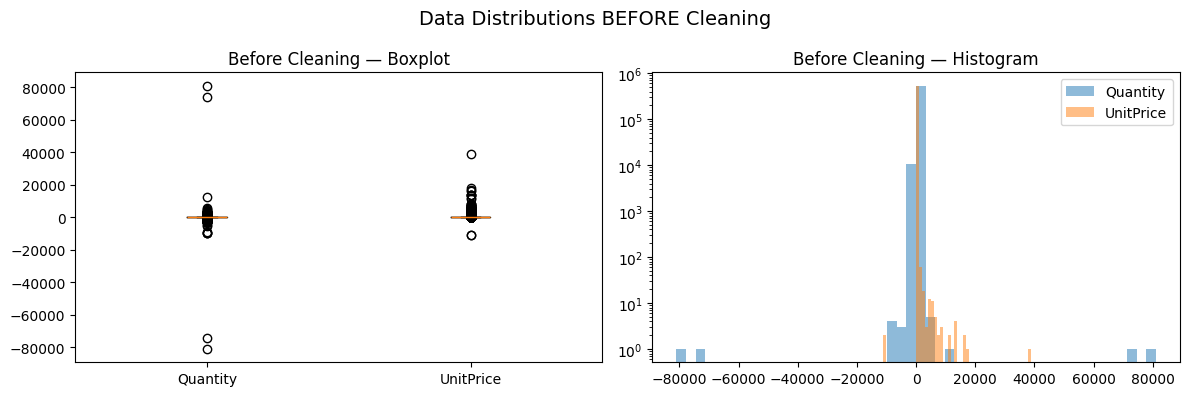

In [ ]:
import matplotlib.pyplot as plt

# Boxplot & hist for raw data (Quantity, UnitPrice)
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Boxplot
axes[0].boxplot([df['Quantity'], df['UnitPrice']], labels=['Quantity','UnitPrice'])
axes[0].set_title("Before Cleaning — Boxplot")

# Histogram (log scale to reveal outliers)
axes[1].hist(df['Quantity'], bins=50, alpha=0.5, label='Quantity')
axes[1].hist(df['UnitPrice'], bins=50, alpha=0.5, label='UnitPrice')
axes[1].set_yscale('log')
axes[1].set_title("Before Cleaning — Histogram")
axes[1].legend()

plt.suptitle("Data Distributions BEFORE Cleaning", fontsize=14)
plt.tight_layout()
plt.show()

## 3b) Clean and prepare


In [ ]:
CUSTOMER_ANALYTICS = True   # True = drop missing CustomerID, False = fill as "Guest"
LOWER_Q, UPPER_Q = 0.001, 0.999  # Quantile thresholds for outlier filtering

df_clean = df.copy()

# 1. Handle missing CustomerID
if CUSTOMER_ANALYTICS:
    df_clean = df_clean[df_clean['CustomerID'].notnull()]
else:
    df_clean['CustomerID'] = df_clean['CustomerID'].fillna("Guest")

# 2. Handle Description missing
df_clean['Description'] = df_clean['Description'].fillna("Unknown")

# 3. Drop invalid values
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# 4. Create SalesAmount
df_clean['SalesAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 5. Outlier filtering (keep 0.1%–99.9%)
for col in ['Quantity', 'UnitPrice']:
    low, high = df_clean[col].quantile([LOWER_Q, UPPER_Q])
    df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= high)]

print("After cleaning:", df_clean.shape)
df_clean.head()

After cleaning: (396807, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


## 3c) Visualise after cleaning

/tmp/ipython-input-3286426630.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([df_clean['Quantity'], df_clean['UnitPrice']], labels=['Quantity','UnitPrice'])


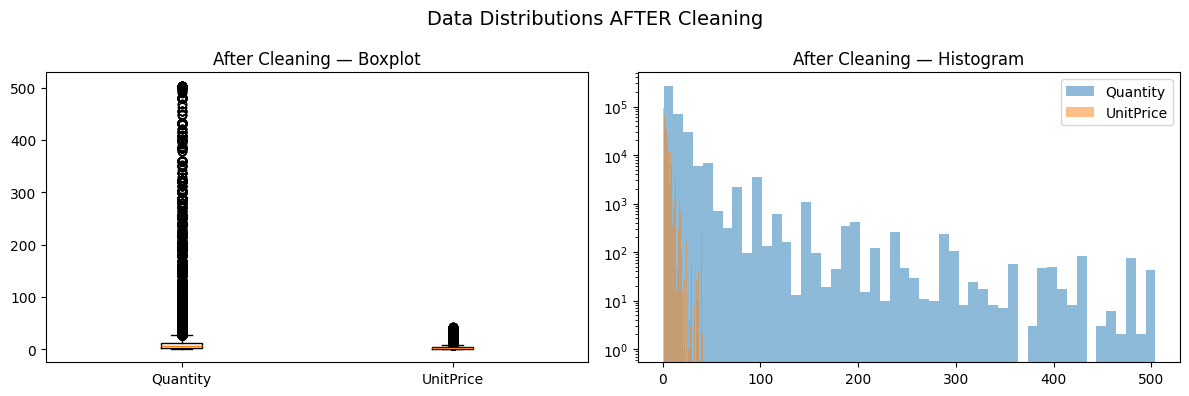

In [ ]:
# Boxplot & hist for cleaned data
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].boxplot([df_clean['Quantity'], df_clean['UnitPrice']], labels=['Quantity','UnitPrice'])
axes[0].set_title("After Cleaning — Boxplot")

axes[1].hist(df_clean['Quantity'], bins=50, alpha=0.5, label='Quantity')
axes[1].hist(df_clean['UnitPrice'], bins=50, alpha=0.5, label='UnitPrice')
axes[1].set_yscale('log')
axes[1].set_title("After Cleaning — Histogram")
axes[1].legend()

plt.suptitle("Data Distributions AFTER Cleaning", fontsize=14)
plt.tight_layout()
plt.show()


## 4) Quick EDA — Top 10 customers by sales



,CustomerID,SalesAmount
1684,14646.0,265207.26
4184,18102.0,237641.30
1874,14911.0,135873.80
54,12415.0,119151.09
3713,17450.0,116727.51
1329,14156.0,116092.03
3756,17511.0,90735.98
992,13694.0,63469.22
3164,16684.0,61976.84
2169,15311.0,60767.90


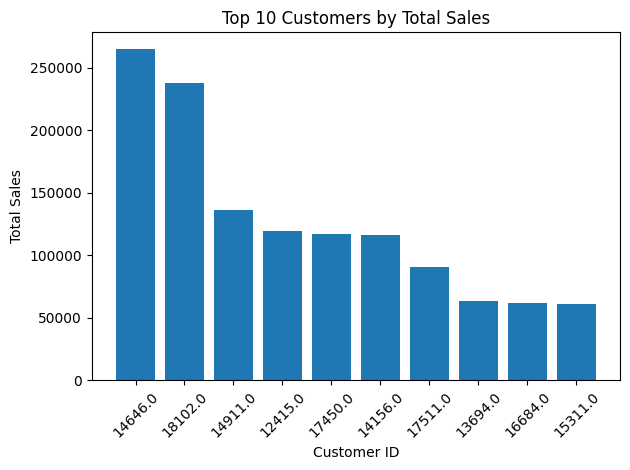

In [ ]:
top_customers = (df_clean.groupby('CustomerID', as_index=False)['SalesAmount']
                 .sum()
                 .sort_values('SalesAmount', ascending=False)
                 .head(10))
display(top_customers)

plt.figure()
plt.bar(top_customers['CustomerID'].astype(str), top_customers['SalesAmount'])
plt.title('Top 10 Customers by Total Sales')
plt.xlabel('Customer ID'); plt.ylabel('Total Sales')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


## 5) Feature Engineering: RFM metrics (Recency, Frequency, Monetary)

This adds depth to customer analysis. Instead of just “big spenders”, we’ll also see:

Recency: Who bought recently (likely to buy again)?

Frequency: Who buys often (loyal customers)?

Monetary: Who spends the most (big-ticket customers)?


In [ ]:
# Ensure datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Snapshot date = day after the last transaction
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics
rfm = (df_clean.groupby('CustomerID').agg({
            'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
            'InvoiceNo': 'nunique',                                   # Frequency
            'SalesAmount': 'sum'                                      # Monetary
        }).reset_index())

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']

# Score each into quintiles (1–5) for segmentation
rfm['R_score'] = pd.qcut(rfm['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Combined RFM score
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

# Show top 10 customers by RFM_Score
rfm.sort_values('RFM_Score', ascending=False).head(10)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
4317,18283.0,4,16,2094.88,5,5,5,15
0,12347.0,2,7,4310.00,5,5,5,15
4308,18272.0,3,6,3078.58,5,5,5,15
4290,18245.0,7,7,2567.06,5,5,5,15
4288,18241.0,10,17,2073.09,5,5,5,15
4280,18230.0,9,7,2810.20,5,5,5,15
4279,18229.0,12,20,7276.90,5,5,5,15
4275,18225.0,3,12,5509.12,5,5,5,15
4273,18223.0,5,14,6484.54,5,5,5,15
4269,18219.0,3,10,2069.77,5,5,5,15



## 6) Monthly sales

We’ll aggregate sales **by month** and build a simple forecast:

/tmp/ipython-input-2015634774.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['SalesAmount']


                     y
InvoiceDate           
2010-12-31   539105.59
2011-01-31   446432.87
2011-02-28   433155.31
2011-03-31   565716.41
2011-04-30   424283.09


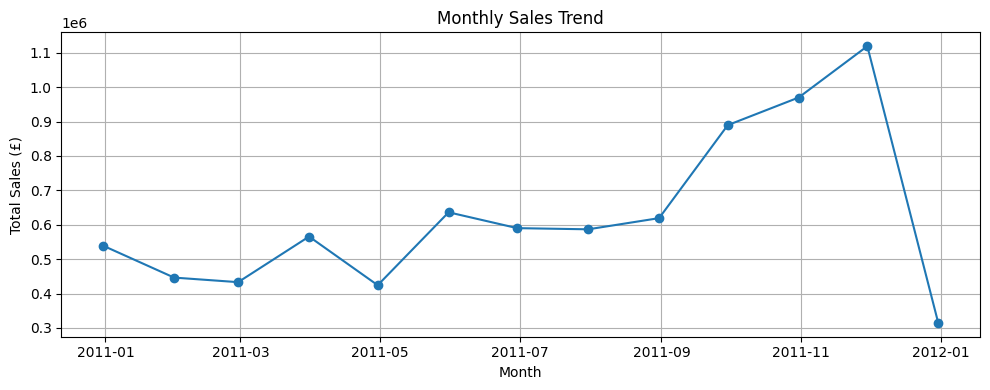

In [ ]:

# Aggregate monthly sales
monthly_sales = (
    df_clean
    .set_index('InvoiceDate')
    .resample('M')['SalesAmount']
    .sum()
    .rename('y')
    .to_frame()
)
print(monthly_sales.head())

# Plot
plt.figure(figsize=(10,4))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (£)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 6b) Forecasting time

INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7zzgpzg8/chel85an.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7zzgpzg8/rgbjyfgi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76161', 'data', 'file=/tmp/tmp7zzgpzg8/chel85an.json', 'init=/tmp/tmp7zzgpzg8/rgbjyfgi.json', 'output', 'file=/tmp/tmp7zzgpzg8/prophet_modelnjchlqwk/prophet_model-20250916064114.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


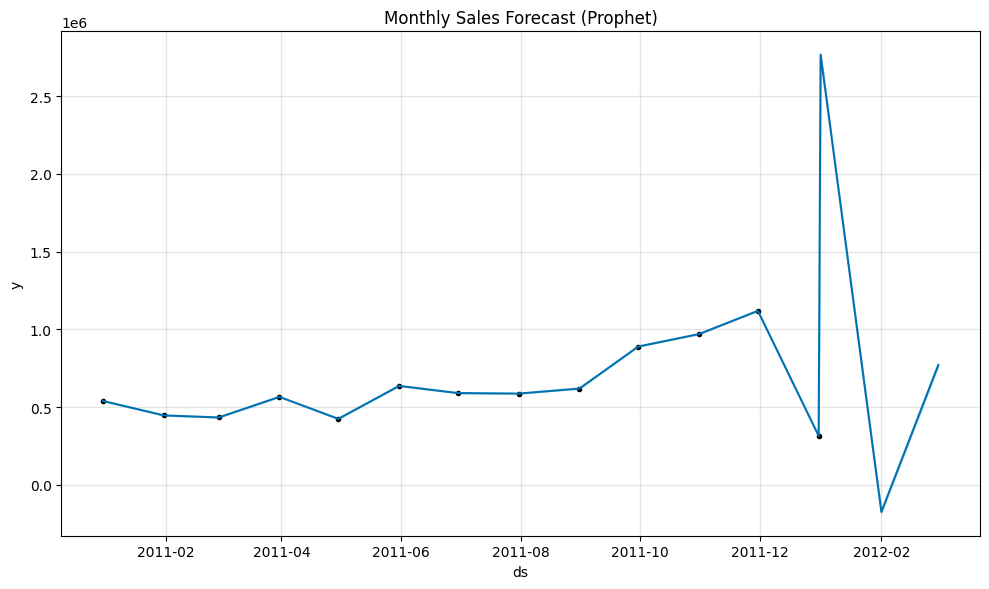

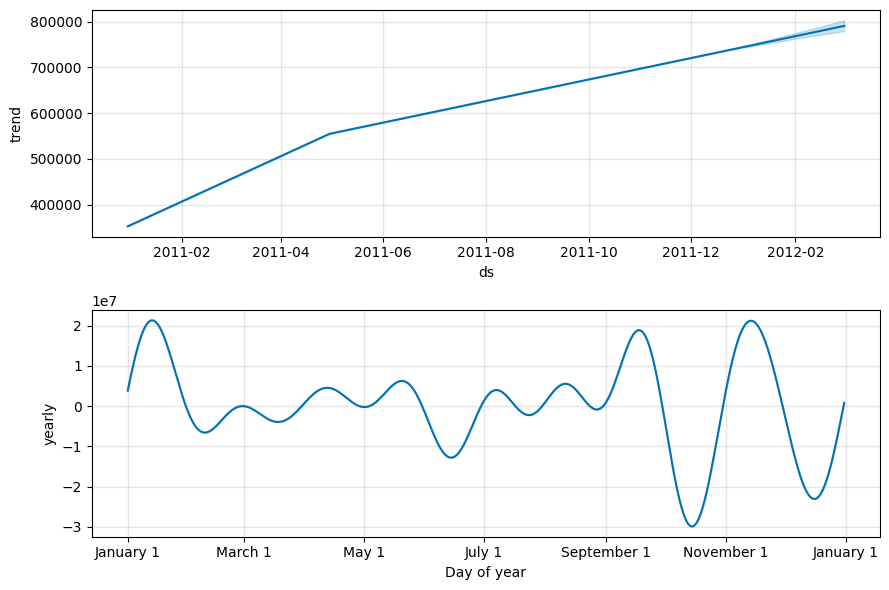

,ds,yhat,yhat_lower,yhat_upper
13,2012-01-01,2.768325e+06,2.766574e+06,2.770376e+06
14,2012-02-01,-1.749206e+05,-1.803820e+05,-1.682950e+05
15,2012-03-01,7.698619e+05,7.585227e+05,7.821512e+05


In [ ]:
from prophet import Prophet

# Prepare input (ds = date, y = value)
sales_df = monthly_sales.reset_index()
sales_df.columns = ['ds', 'y']

# Build and fit model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(sales_df)

# Forecast 3 months ahead
future = model.make_future_dataframe(periods=3, freq='MS')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Monthly Sales Forecast (Prophet)")
plt.tight_layout()
plt.show()

# Plot components (trend + seasonality)
model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Forecast table
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(3)


## 7) Discussion — What did we learn?

- **Manual workflow strengths:** control, transparency, and customizability.  
- **Where it’s slow:** repetitive cleaning, boilerplate feature engineering, rapid iteration.  
- **Why it matters anyway:** Understanding this pipeline helps you validate AI outputs and avoid pitfalls (e.g., counting returns as revenue, double-counting orders, etc.).
